Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


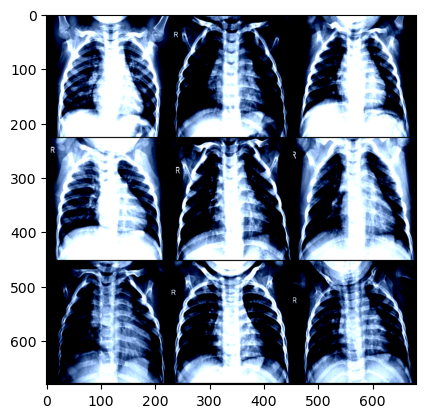

In [20]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid 

BATCH_SIZE = 32
SHUFFLE = False # Warning message that it should be turned off for train/val loaders check later
NUM_WORERS = 7 # 7 because that what it suggested in a warning message
PERSISTENT_WORKERS = True # Suggested to do this in a warning message for fatser init


DATA_DIR = "/Users/emillundin/Desktop/D7047E/Project/Data/chest_xray" # Change this to chest_xray folder
data_dir_train = DATA_DIR + "/train"
data_dir_val = DATA_DIR + "/val"
data_dir_test = DATA_DIR + "/test"

# Some desired transforms for ResNet50
# https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet50.html#torchvision.models.resnet50
train_transform = transforms.Compose(
    [
        transforms.Resize(size = (256, 256)),
        transforms.CenterCrop(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # 
    ]
)

dataset_train = datasets.ImageFolder(data_dir_train, train_transform)
dataset_val = datasets.ImageFolder(data_dir_val, train_transform)
dataset_test = datasets.ImageFolder(data_dir_test, transforms.ToTensor())

train_loader = DataLoader(
    dataset_train, 
    batch_size=BATCH_SIZE, 
    shuffle=SHUFFLE, 
    num_workers=NUM_WORERS, 
    persistent_workers= PERSISTENT_WORKERS
)
val_loader = DataLoader(
    dataset_val, 
    batch_size=BATCH_SIZE, 
    shuffle=SHUFFLE, 
    num_workers=NUM_WORERS, 
    persistent_workers= PERSISTENT_WORKERS
)
test_loader = DataLoader(
    dataset_test, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORERS, 
    persistent_workers= PERSISTENT_WORKERS
)

#Plot some example images
examples = next(iter(train_loader))
images, labels = examples
grid = make_grid(images[:9], nrow=3)
plt.imshow(grid.permute(1, 2, 0))

In [21]:
from torchvision.models import resnet50, ResNet50_Weights

#Load best resNet50 weights
model = resnet50(weights=ResNet50_Weights.DEFAULT)

#Change output layer to 2 classes
model.fc = torch.nn.Linear(
    in_features=2048,
    out_features=2,
    bias=True
)

#Freeze all layers except fc
for name, param in model.named_parameters():
    if "fc.weight" in name or "fc.bias" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [22]:
import lightning as L
import torch.nn.functional as F

class Classificator(L.LightningModule):
    def __init__(self, rn50):
        super().__init__()
        self.rn50 = rn50

    def training_step(self, batch):
        images, labels = batch
        output = self.rn50(images)
        _, preds = torch.max(output, dim=1)
        loss = F.cross_entropy(output, labels) # Quickfix check if BCE is better later
        train_acc = torch.sum(preds == labels) / len(labels) # Batch acc fix later to epoch acc
        self.log_dict({"Traning loss" : loss, "Training accuracy" : train_acc}, prog_bar=True)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        output = self.rn50(images)
        loss = F.cross_entropy(output, labels) # Quickfix check if BCE is better later
        _, preds = torch.max(output, dim=1)
        val_acc = torch.sum(preds == labels) / len(labels) # Batch acc fix later to epoch acc
        self.log_dict({"Validation loss" : loss, "Validation accuracy": val_acc}, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [23]:
num_epochs = 10
classifier = Classificator(model)

trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=num_epochs,
)
trainer.fit(
    model = classifier,
    train_dataloaders = train_loader, 
    val_dataloaders = val_loader
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



  | Name | Type   | Params
--------------------------------
0 | rn50 | ResNet | 23.5 M
--------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [27]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

Reusing TensorBoard on port 6006 (pid 22426), started 0:00:05 ago. (Use '!kill 22426' to kill it.)